Welcome to the first lab
Below you can see the instructions to proceed with the needed tasks. You should complete the implementation of the functions mentioned below. 

For the lab submission, you should write a report explaining your implementation and showing the results .. You also are required to upload the code with the report.

Have fun :)


In [29]:
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Conv2D
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from keras.layers.core import Activation
from tensorflow.keras.utils import to_categorical
import os
import keras
import numpy as np 
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, KFold


try:
    import nibabel as nib
except:
    raise ImportError('Install NIBABEL')

(79, 95, 79)


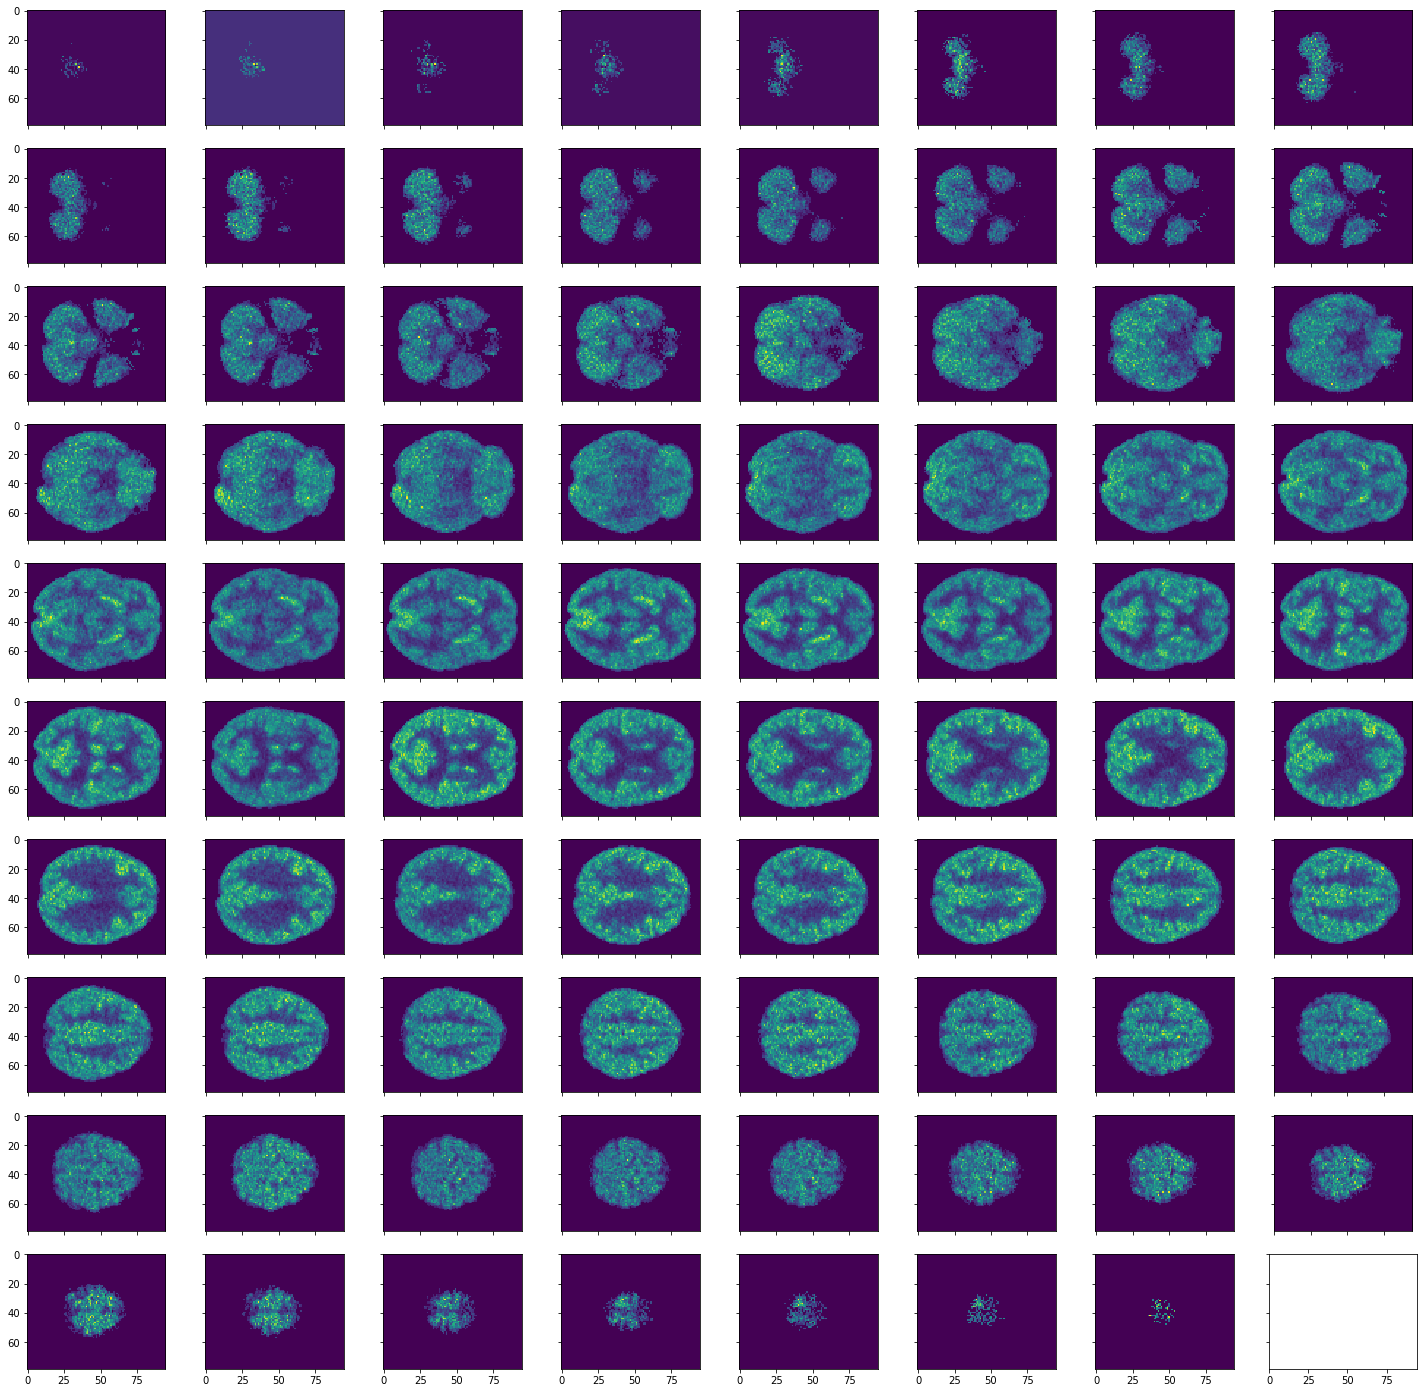

In [2]:
#here I'm visualizing a scan, so that you can see the different sclices of the brain

local_normal = os.getcwd() + '\\data\\AD\\AD_ADNI_2489.nii'
pet_img=nib.load(local_normal).get_fdata()
print(pet_img.shape)

fig, axs = plt.subplots(10,8, figsize = (25, 25),sharex='all', sharey='all')
for i in range (10):
    for j in range (8):
        index = i*8 + j
        axs[i,j].imshow(pet_img[:,:,index])
        
        if index+1 > 78:
            break

In [3]:
#write you code to load the data and perform intensity normalization
dim_x = 79
dim_y = 95
dim_z = 60 # I skip the first 10 layers and the last 9

# The images are 79x95x79.
# Skipping first 10 and last 9 layers.

def load_all_nii_data(path, filenames, category):
    data = np.zeros((len(filenames),dim_x,dim_y,dim_z,1))
    labels = np.zeros(len(filenames))

    #Add your code here
    for index, file in enumerate(filenames):
        #print(path + file)
        #print(index)
        
        # Load file.
        image = nib.load(path + file).get_fdata()
        
        # Normalize intensity in the image.
        image = intensity_normalize(image)
        
        # Add new axis to the image array.
        image = image[:,:,:,np.newaxis]
        # Add the label of the image.
        image[0][0][0][:] = category
        # Add the image to the data array, skipping the first 10 and last 9 layers of the image.
        data[index,:,:,:] = image[:,:,10:-9,:]
        
        # Save label.
        labels[index] = category
        
    #print(labels)
    #print(data[0,30,:,0,:])
    
    return data, labels

# don't forget to apply the normalization individually per each input scan
def intensity_normalize(data):
    # Min-Max scaling
    data_scaled = (data - data.min())/(data.max() - data.min()) 
    
    return data_scaled
    
ad_files = os.listdir(os.getcwd() + '\\data\\AD')
cn_files = os.listdir(os.getcwd() + '\\data\\CN')
mci_files = os.listdir(os.getcwd() + '\\data\\MCI')
    
cn_data, cn_labels = load_all_nii_data(os.getcwd() + '\\data\\CN\\', cn_files, 0)
ad_data, ad_labels = load_all_nii_data(os.getcwd() + '\\data\\AD\\', ad_files, 1)
mci_data, mci_labels = load_all_nii_data(os.getcwd() + '\\data\\MCI\\', mci_files, 2)

all_data = np.concatenate((cn_data, ad_data, mci_data), axis=0)
all_labels = np.concatenate((cn_labels, ad_labels, mci_labels), axis=0)

##for VGG network you need to provde labels as categorical classes
## you can use tensorflow.keras.utils.to_categorical

In [4]:
print(all_data.shape)

(468, 79, 95, 60, 1)


In [5]:
# here wirte the code to split the data into train and test datasets
#leave 10% of your data for testing
def split_data(data):
    # New array which excludes the label column
    #input_data = np.delete(all_data, 0, axis=4)
    input_data = np.squeeze(all_data, axis=4)
    x_train, x_test, y_train, y_test = train_test_split(input_data, all_labels, test_size=0.1)
    return x_train, x_test, y_train, y_test

In [10]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')
print(model.summary())

553467904/553467096 [==============================] - 59s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [33]:
# define your VGG model
def create_VGG_3Dmodel(dim_x, dim_y, dim_z):
    # input layer
    input_layer = Input(shape=(dim_x, dim_y, dim_z, 1))
    
    #write the code for creating convolution blocks and MLP
    #you can try different values of Dropout as well
    conv1 = Conv3D(filters=16, kernel_size=3, padding='same', activation='relu')(input_layer)
    #conv1 = Activation(LeakyReLU)(conv1)
    #conv1 = BatchNormalization()(conv1)
    #conv1 = Conv3D(filters=16, kernel_size=3)(conv1)
    
    #conv2 = Conv3D(filters=16, kernel_size=3, padding='same', activation='relu')(conv1)
    #conv2 = Activation(LeakyReLU)(conv2)
    #conv2 = BatchNormalization()(conv2)
    #conv2 = Conv3D(filters=16, kernel_size=3)(conv2)
    flat = Flatten()(conv1)
    
    output_layer = Dense(3, activation='softmax')(flat)
    
    # define the model with input layer and output layer
    model = Model(inputs=input_layer, outputs=output_layer)
    model.summary()

    return model


In [35]:
model = create_VGG_3Dmodel(all_data.shape[1], all_data.shape[2], all_data.shape[3])
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adadelta(lr=0.01), metrics=['acc'])
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=0, patience=5, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, verbose=0, patience=10, mode='auto')

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 79, 95, 60, 1)]   0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 79, 95, 60, 16)    448       
_________________________________________________________________
flatten (Flatten)            (None, 7204800)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 21614403  
Total params: 21,614,851
Trainable params: 21,614,851
Non-trainable params: 0
_________________________________________________________________


The next step is to perform the cross validation, you should try performing it for 15 rounds and in each round you try with k starts from 2 to 10

Here is some guidence reagarding optimizer and early stopping conditions

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adadelta(lr=0.01), metrics=['acc'])

reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=0, patience=5, mode='auto')

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, verbose=0, patience=10, mode='auto')


Keep in mind to save to the disk the models achieving the highest validation accuracy 

You also need to store the trainig as well as validation accurcies to create plot with 95% confidence intervals similar to this one

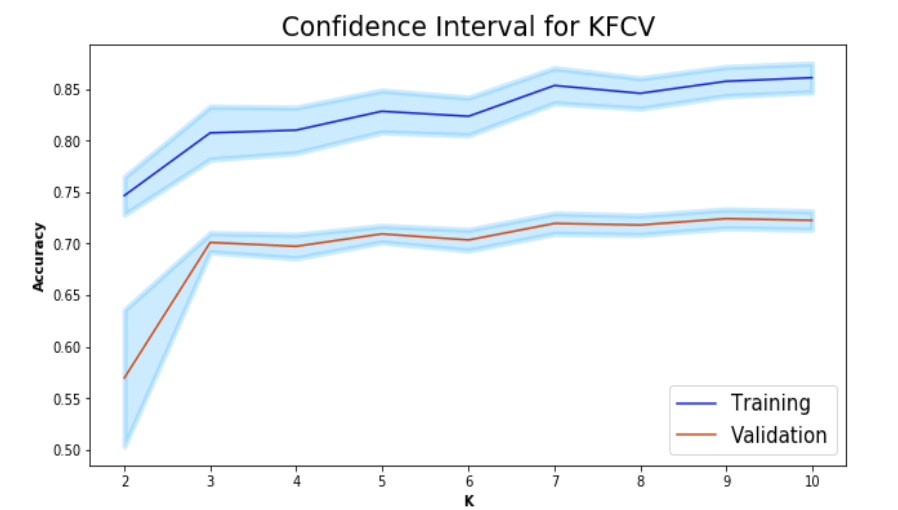

In [15]:
x_train, x_test, y_train, y_test = split_data(all_data)

In [16]:
x_train.shape

(421, 79, 95, 60)

In [17]:
y_train.shape

(421,)

In [23]:
# Encodes the labels
y_train_enc = to_categorical(y_train, num_classes=3)
y_test_enc = to_categorical(y_test, num_classes=3)

In [32]:
y_train_enc.shape

(421, 3)

In [37]:
model.fit(x=x_train, y=y_train_enc, validation_data=(x_test, y_test_enc), callbacks=[reduce, early])

14/14 [==============================] - 121s 9s/step - loss: 2.3856 - acc: 0.3515 - val_loss: 5.0027 - val_acc: 0.2979


#### Perform the KFCV (15 epochs)

In [38]:
kf = KFold(10)
start = time.time()

for train_idx, test_idx in kf.split(x_train):
    #print(x_train[train_idx])
    
    model.fit(x=x_train[train_idx], y=y_train_enc[train_idx], validation_data=(x_test, y_test_enc), callbacks=[reduce, early], epochs=15)
    #print('Model evaluation', model.evaluate(x_test[test_idx], y_test[test_idx]))

print(f'Elapsed time: {time.time() - start}')

Epoch 1/15
12/12 [==============================] - 42s 3s/step - loss: 2.6974 - acc: 0.3148 - val_loss: 2.4682 - val_acc: 0.4894
Epoch 2/15
12/12 [==============================] - 41s 3s/step - loss: 2.2613 - acc: 0.3571 - val_loss: 2.9658 - val_acc: 0.3830
Epoch 3/15
12/12 [==============================] - 42s 3s/step - loss: 2.4211 - acc: 0.3254 - val_loss: 2.1586 - val_acc: 0.2979
Epoch 4/15
12/12 [==============================] - 41s 3s/step - loss: 1.9186 - acc: 0.3783 - val_loss: 1.1785 - val_acc: 0.6383
Epoch 5/15
12/12 [==============================] - 42s 3s/step - loss: 2.0060 - acc: 0.3624 - val_loss: 3.5111 - val_acc: 0.3830
Epoch 6/15
12/12 [==============================] - 45s 4s/step - loss: 1.6286 - acc: 0.4603 - val_loss: 2.0023 - val_acc: 0.4681
Epoch 7/15
12/12 [==============================] - 43s 4s/step - loss: 1.2939 - acc: 0.5132 - val_loss: 1.5047 - val_acc: 0.3830
Epoch 8/15
12/12 [==============================] - 42s 3s/step - loss: 1.6917 - acc: 0.45

#### Get the model with the highest validation accuracy and perform the fine-tuning. Freeze convolutional layers. You can train the model using the whole training data for certain number of epochs without EARLY STOPPING. You can change the optimizer, and choose smaller learning rate

#### Evaluate the model accuracy on the test set and compute the evaluation metrics (Confusion Matrix, Sensitivity, Specificity, and plot ROC curve)